In [70]:
import numpy as np
import pandas as pd
import os
import cv2
import joblib
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.metrics.pairwise import cosine_similarity
from pandas.core.common import flatten
from torchvision.transforms import transforms
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import swifter
from sklearn.model_selection import train_test_split


In [71]:
import warnings
warnings.filterwarnings("ignore")

In [72]:
df = pd.read_csv('styles.csv', on_bad_lines='skip')
df['image'] = df.apply(lambda row:str(row['id']) + '.jpg',axis=1)
df = df.reset_index(drop=True)

sample_dir = 'sample'
sample_images = {os.path.splitext(f)[0] for f in os.listdir(sample_dir) if os.path.isfile(os.path.join(sample_dir, f))}

# Filtrer le DataFrame pour inclure uniquement les images disponibles dans 'sample'
df = df[df['id'].astype(str).isin(sample_images)]
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
89,33822,Men,Footwear,Shoes,Sports Shoes,White,Summer,2012.0,Sports,Puma Men Axis White & Grey Sports Shoes,33822.jpg
105,49461,Men,Footwear,Shoes,Casual Shoes,Blue,Summer,2012.0,Casual,Vans Men Blue Era Scilla Plaid Shoes,49461.jpg
121,2618,Women,Footwear,Shoes,Flats,Silver,Spring,2010.0,Casual,Carlton London Women Silver Wedge Sandal,2618.jpg
217,51031,Women,Apparel,Innerwear,Bra,White,Summer,2017.0,Casual,Enamor White Bra,51031.jpg
220,55491,Women,Personal Care,Lips,Lip Gloss,Brown,Spring,2017.0,Casual,Revlon Gold Dust Poussiere Doree Colorburst Li...,55491.jpg


In [74]:
# Diviser le DataFrame en ensembles d'entraînement et de test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Function to load the path
def image_location(img):
    path = "sample/"
    fin = path + img
    return fin

def import_img(image):
    imag = cv2.imread(image_location(image))
    return imag

# Fonction pour afficher les images
def show_images(images, rows=1, cols=1, figsize=(12, 12)):
    fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=figsize)
    for index, name in enumerate(images):
        axes.ravel()[index].imshow(cv2.cvtColor(images[name], cv2.COLOR_BGR2RGB))
        axes.ravel()[index].set_title(name)
        axes.ravel()[index].set_axis_off()
    plt.tight_layout()

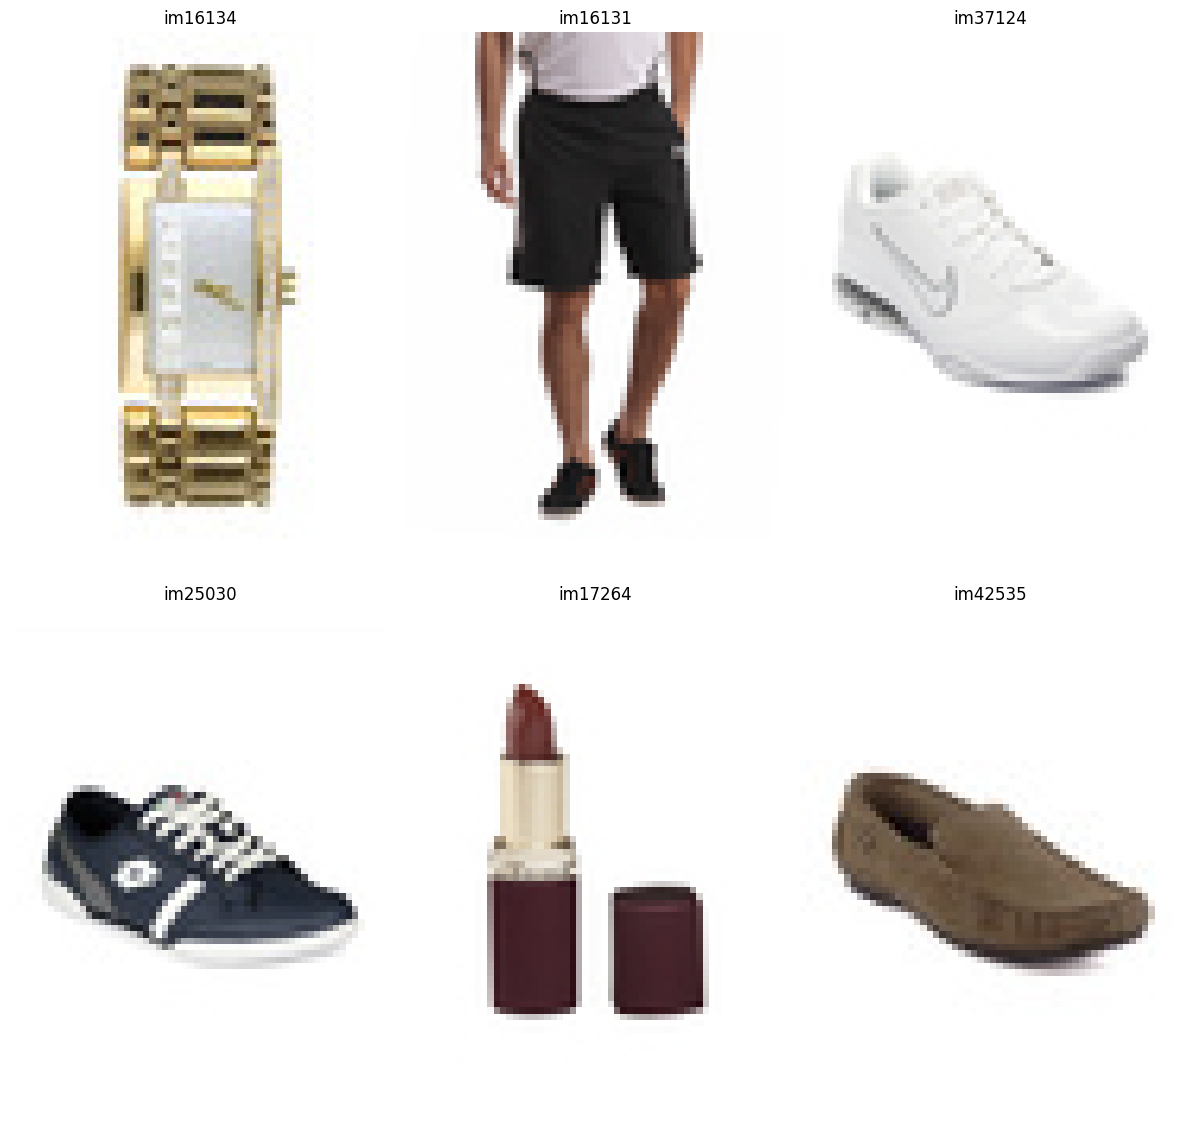

In [75]:
figures = {'im'+str(i): import_img(row.image) for i, row in df_train.sample(6).iterrows()}
show_images(figures, 2, 3)

In [76]:
# Définir la forme d'entrée
width = 224
Height = 224

# Charger le modèle pré-entraîné
resnetmodel = models.resnet18(pretrained=True)

# Sélectionner la couche
layer = resnetmodel._modules.get('avgpool')

# Extraire le vecteur intégré de l'image et le sauvegarder dans un objet unique
s_data = transforms.Resize((224, 224))

# Normaliser les données
standardize = transforms.Normalize(mean=[0.7, 0.6, 0.3], std=[0.2, 0.3, 0.1])

# Convertir en tenseur
Convert_tensor = transforms.ToTensor()

# Créer l'objet pour les images manquantes
missing_img = []

In [77]:
# Fonction pour obtenir les embeddings
def vector_extraction(resnetmodel, image_id):
    # Exception pour gérer les images manquantes
    try:
        img = Image.open(image_location(image_id)).convert('RGB')
        
        t_img = standardize(Convert_tensor(s_data(img))).unsqueeze(0)
       
        embeddings = torch.zeros(512)

        def select_d(m, i, o):
            embeddings.copy_(o.data.reshape(o.data.size(1)))
        hlayer = layer.register_forward_hook(select_d)
        resnetmodel(t_img)
        hlayer.remove()
        return embeddings   
        
    except FileNotFoundError:
        # Stocker l'index de l'image manquante dans la liste missing_img
        missing_img.append(df[df['image'] == image_id].index[0])

# Extraire les embeddings pour une image d'exemple
sample_embedding_0 = vector_extraction(resnetmodel, df_train.iloc[0].image)


(80, 60, 3)
(80, 60, 3)

Cosine similarity: tensor([0.9984])



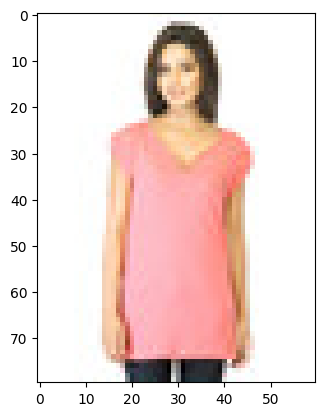

In [78]:
# Afficher l'image d'exemple et ses embeddings
img_array = import_img(df_train.iloc[0].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)

sample_embedding_1 = vector_extraction(resnetmodel, df_train.iloc[1001].image)

img_array = import_img(df_train.iloc[1001].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)

cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cos_sim = cos(sample_embedding_0.unsqueeze(0), sample_embedding_1.unsqueeze(0))
print('\nCosine similarity: {0}\n'.format(cos_sim))

In [79]:
df_embeddings = df_train

# Boucle sur les images pour obtenir les embeddings
map_embeddings = df_embeddings['image'].swifter.apply(lambda img: vector_extraction(resnetmodel, img))

df_embs = map_embeddings.apply(pd.Series)
df_embs.to_csv('fashion.csv')
df_embs = pd.read_csv('./fashion.csv')
df_embs.drop(['Unnamed: 0'], axis=1, inplace=True)
df_embs.dropna(inplace=True)

# Exporter sous forme de pickle
joblib.dump(df_embs, 'df_embs.pkl', 9)

# Charger le pickle
df_embss = joblib.load('./df_embs.pkl')

cosine_sim = cosine_similarity(df_embss)
cosine_sim[:4, :4]

Pandas Apply:   0%|          | 0/1600 [00:00<?, ?it/s]

array([[1.        , 0.99844975, 0.99836645, 0.99842604],
       [0.99844975, 1.        , 0.9982893 , 0.99850313],
       [0.99836645, 0.9982893 , 1.        , 0.9984152 ],
       [0.99842604, 0.99850313, 0.9984152 , 1.        ]])

In [80]:
# Mettre à jour index_values pour correspondre à df_embeddings
index_values = pd.Series(range(len(df_embeddings)), index = df_embeddings.index)
index_values.head()

22029    0
5698     1
18997    2
16371    3
9660     4
dtype: int64

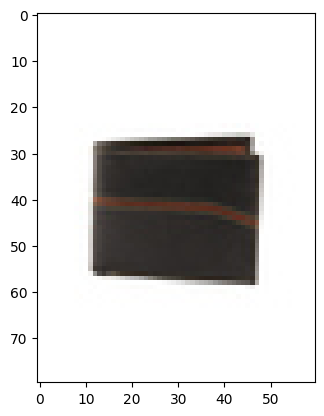

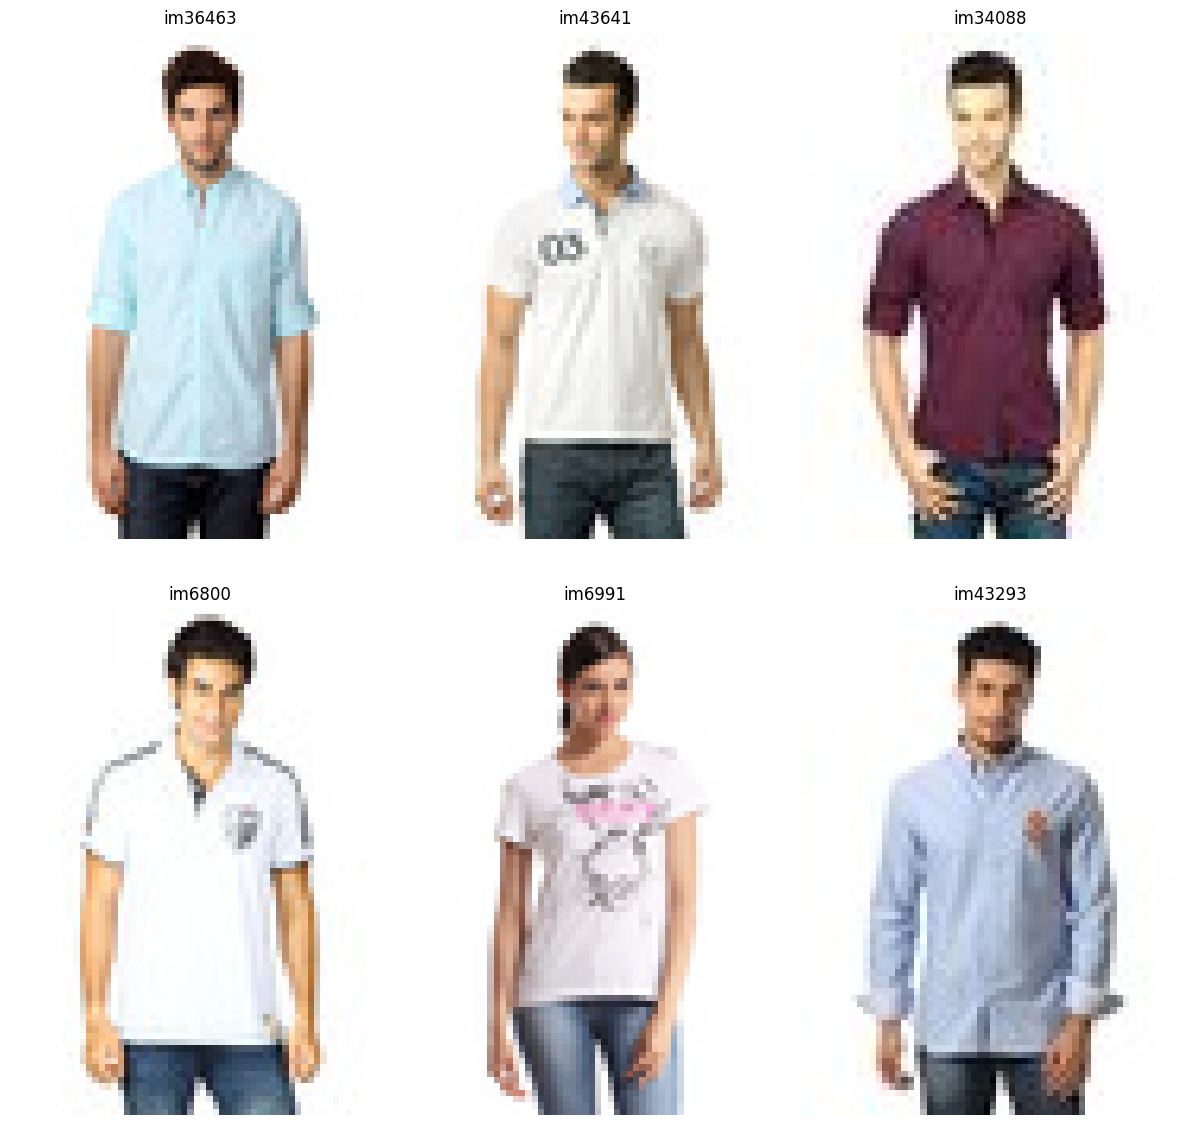

In [81]:
def recommend_images(ImId, df, top_n=6):
    if ImId not in index_values:
        raise ValueError(f"Index {ImId} is out of bounds for the DataFrame with size {len(df)}")
    sim_ImID = index_values[ImId]
    sml_scr = list(enumerate(cosine_sim[sim_ImID]))
    sml_scr = sorted(sml_scr, key=lambda x: x[1], reverse=True)
    sml_scr = sml_scr[1:top_n+1]
    # ImId_rec retourne les index des éléments similaires
    ImId_rec = [i[0] for i in sml_scr]
    ImId_sim = [i[1] for i in sml_scr]
    return index_values.iloc[ImId_rec].index, ImId_sim


def Rec_viz_image(input_imageid):
    # Obtenir des recommandations
    idx_rec, idx_sim = recommend_images(input_imageid, df_embeddings, top_n=6)
    plt.imshow(cv2.cvtColor(import_img(df_embeddings.iloc[input_imageid].image), cv2.COLOR_BGR2RGB))
    figures = {'im'+str(i): import_img(row.image) for i, row in df_embeddings.loc[idx_rec].iterrows()}
    show_images(figures, 2, 3)

Rec_viz_image(373)

In [82]:
df_test_embeddings = df_test.copy()
df_test_embeddings['embedding'] = df_test_embeddings['image'].swifter.apply(lambda img: vector_extraction(resnetmodel, img))
df_test_embeddings = df_test_embeddings.dropna(subset=['embedding'])


Pandas Apply:   0%|          | 0/400 [00:00<?, ?it/s]

In [83]:
def precision_at_k(recommended_items, relevant_items, k):
    recommended_at_k = recommended_items[:k]
    num_relevant_at_k = len(set(recommended_at_k).intersection(set(relevant_items)))
    return num_relevant_at_k / k

def recall_at_k(recommended_items, relevant_items, k):
    recommended_at_k = recommended_items[:k]
    num_relevant_at_k = len(set(recommended_at_k).intersection(set(relevant_items)))
    return num_relevant_at_k / len(relevant_items)

def f1_score_at_k(precision, recall):
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

def mean_average_precision(recommended_items, relevant_items):
    num_relevant = 0
    precision_sum = 0.0
    for i, item in enumerate(recommended_items):
        if item in relevant_items:
            num_relevant += 1
            precision_sum += num_relevant / (i + 1)
    return precision_sum / len(relevant_items)


In [84]:
k = 5
precisions = []
recalls = []
f1_scores = []
map_scores = []

for idx, row in df_test_embeddings.iterrows():
    recommended_indices, _ = recommend_images(idx, df_train, top_n=k)
    recommended_items = df_train.iloc[recommended_indices].image.tolist()
    relevant_items = [row['image']]  # Utilisez les informations pertinentes que vous avez

    precision = precision_at_k(recommended_items, relevant_items, k)
    recall = recall_at_k(recommended_items, relevant_items, k)
    f1 = f1_score_at_k(precision, recall)
    map_score = mean_average_precision(recommended_items, relevant_items)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    map_scores.append(map_score)

avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1_score = np.mean(f1_scores)
avg_map_score = np.mean(map_scores)

print(f'Precision@{k}: {avg_precision}')
print(f'Recall@{k}: {avg_recall}')
print(f'F1-Score@{k}: {avg_f1_score}')
print(f'Mean Average Precision: {avg_map_score}')


ValueError: Index 41792 is out of bounds for the DataFrame with size 1600